# Machine Vision<br> - Motion

## 1. Background subtraction
 we use background subtraction techniques to detect objects of interest in a video. We use a dynamic background that is continuously updated and threshold every frame of the video to detect new objects.


**1.1. Introduction**

We will implement object detection through background subtraction. We work with grayscale images. The background is a dynamic model where each pixel is described by a Gaussain (i.e. mean and variance). The background model for each pixel is updated after each frame according to the equations:

$$
\mu_{t+1} = \alpha \mu_t + (1-\alpha) z_{t+1} \qquad \qquad \qquad \qquad \qquad \qquad (1) \\
\sigma_{t+1}^2 = \alpha [\sigma_t^2 + (\mu_{t+1} - \mu_t)^2] + (1-\alpha)(z_{t+1} - \mu_{t+1})^2 \qquad \ \   (2)
$$

where $\alpha$ controls the rate of adaptation $(0 < \alpha < 1)$ and $z_t$ is the observed pixel value at time $t$. With this model we can decide whether a pixel contains an object of interest with the formula

$$
| z_t - \mu_t | > 3 \, \text{max}(\sigma_t, \sigma_{rcam}) \qquad \qquad (3)
$$

where $\sigma_{rcam}$ represents the standard deviation of the camera noise. We first extact the first two frames from a video and estimate $\sigma_{rcam}$.

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read first two frames
cap = cv2.VideoCapture('test.mp4')
ret, color1 = cap.read()
ret, color2 = cap.read()
cap.release()

# We work with grayscale images (range [0,1])
frame1 = cv2.cvtColor(color1, cv2.COLOR_BGR2GRAY)/255
frame2 = cv2.cvtColor(color2, cv2.COLOR_BGR2GRAY)/255

# Estimate camera noise
diff = frame1.ravel() - frame2.ravel()
sigma_cam = np.std(diff)

# Video compression algorithms may distort the noise distribution.
# Enforce a minimum.
sigma_cam = np.max([sigma_cam, 1/255])
print('Camera noise (std): %.4f' %(sigma_cam*255))

Camera noise (std): 1.0000


Next we initialize the model.

In [0]:
# Initialize mean and variance images
mean_img = frame1
var_img = sigma_cam * np.ones_like(frame1)

# The current state is stored in a dictionary
state_initial = {"alpha": 0.99,
                 "sigma_cam": sigma_cam,
                 "mean_img": mean_img,
                 "var_img": var_img}

# You can access the values by
alpha = state_initial["alpha"] # Or: state.get("alpha")

# And you can change the values by
state_initial["alpha"] = 0.9999

**1.2. Update background model** $\quad$ <font color=red></font>



In [0]:
# INPUT   
# frame : The current grayscale image
# state : The current state (as define above)
#
# OUTPUT  
# state : Updated state, where state["mean_img"] and
#         state["var_img"] have been updated.
#
def updateBackgroundModel(frame, state):
    
    var_img=state["var_img"]
    mean_img=state["mean_img"]
    mean_img_t=alpha*mean_img+(1-alpha)*frame
    var_img_t=alpha*(var_img+(mean_img_t-mean_img)**2)+(1-alpha)*(frame-mean_img_t)**2
    state = {"alpha": 0.99999,
            "sigma_cam": sigma_cam,
            "mean_img": mean_img_t,
            "var_img": var_img_t}
    

    return state


**1.3. Threshold frame** $\quad$ <font color=red></font>


In [0]:
# INPUT   
# frame : The current grayscale image
# state : The current state
#
# OUTPUT  
# thresh : Thresholded image
#
def thresholdFrame(frame, state):
    
    
    # This line can be removed
    thresh = np.zeros(frame.shape, dtype=np.bool)
    var_img=state["var_img"]
    mean_img=state["mean_img"]
    sigma_cam=state["sigma_cam"]
    side1=np.abs(frame-mean_img)
    side2=3*np.maximum(np.sqrt(var_img),sigma_cam)
    thresh=side1 > side2

    return thresh



**1.4. Testing**



(-0.5, 959.5, 539.5, -0.5)

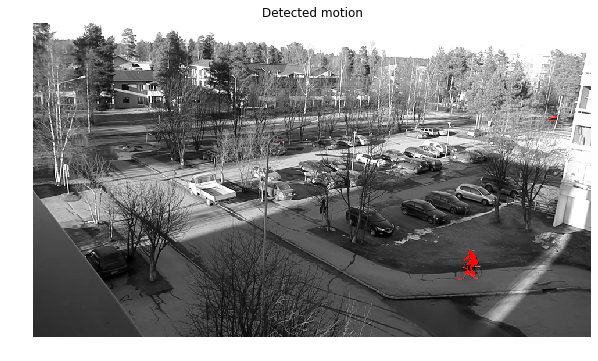

In [0]:
cap = cv2.VideoCapture('test.mp4')

N = 100
i = 0

state = state_initial.copy()

while i < N:

    ret, color = cap.read()
    if ret == False:
        break
        
    # Convert to grayscale
    frame = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)/255
    
    # Update
    state = updateBackgroundModel(frame, state);
    
    i += 1
     
cap.release()

# Threshold
thresh = thresholdFrame(frame, state);

# Overlay thresholded image on the frame
overlayed = np.stack((frame,)*3, axis=-1)
red = frame.copy()
red[thresh.astype(np.bool)] = 1
overlayed[:,:,0] = red

# Display
plt.figure(figsize=(10,7))
plt.imshow(overlayed)
plt.title('Detected motion')
plt.axis('off')

**1.5. Improvements ()**

We can try different values of $\alpha$ (e.g. 0.8, 0.99, and 0.9999) and choose the most appropriate. we can also use morphological operations to remove spurious detections form the thresholded image.

**1.6. Generate an output video (optional)**

Uncomment the following code cell to generate a short output video showing the detected regions.

In [0]:
''''
cap = cv2.VideoCapture('test.mp4')

fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (width,height))

N = 200
i = 0

state = state_initial.copy()

while i < N:

    ret, color = cap.read()
    if ret == False:
        break

    # Convert to grayscale
    frame = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)/255
    
    # Threshold
    thresh = thresholdFrame(frame, state);
    
    # Update
    state = updateBackgroundModel(frame, state);
    
    # Write output frame
    red = color[:,:,2]
    red[thresh.astype(np.bool)] = 255
    color[:,:,2] = red
    out.write(color)
    
    i += 1
     
cap.release()
out.release()
''''